In [1]:
import os
import sys
import json
import time
import pickle
import gspread
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy import integrate, fftpack, signal, stats

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events,
    get_evoked_traces,
    get_evoked_firing_rates,
    find_nearest_ind
)
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import remove_lfp_offset
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib notebook

Load CCF for identifying cortical areas

In [5]:
mcc = MouseConnectivityCache(resolution=10)
str_tree = mcc.get_structure_tree()

Load Zap_Zip-log_exp to get metadata for experiments

In [6]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

Define areas of interest to plot population activity

In [7]:
areas_of_interest = {
    'MO': [
        'MOp1', 'MOp2/3', 'MOp5', 'MOp6a', 'MOp6b',
        'MOs1', 'MOs2/3', 'MOs5', 'MOs6a', 'MOs6b'
    ],
    'ACA': [
        'ACAd1', 'ACAd2/3', 'ACAd5', 'ACAd6a', 'ACAd6b',
        'ACAv1', 'ACAv2/3', 'ACAv5', 'ACAv6a', 'ACAv6b'
    ],
    'SS': [
        'SSp-bfd1', 'SSp-bfd2/3', 'SSp-bfd4', 'SSp-bfd5', 'SSp-bfd6a', 'SSp-bfd6b',
        'SSp-ll1', 'SSp-ll2/3', 'SSp-ll4', 'SSp-ll5', 'SSp-ll6a', 'SSp-ll6b',
        'SSp-tr1', 'SSp-tr2/3', 'SSp-tr4', 'SSp-tr5', 'SSp-tr6a', 'SSp-tr6b'
    ],
    'VIS': [
        'VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b',
        'VISam1', 'VISam2/3', 'VISam4', 'VISam5', 'VISam6a', 'VISam6b',
        'VISpm1', 'VISpm2/3', 'VISpm4', 'VISpm5', 'VISpm6a', 'VISpm6b',
        'VISrl1', 'VISrl2/3', 'VISrl4', 'VISrl5', 'VISrl6a', 'VISrl6b',
    ],
    'MO-TH': [
        'AV', 'CL', 'MD', 'PO', 'RT', 'VAL', 'VPL', 'VPM', 'VM'
    ],
}

In [8]:
area_colors = {
    'MO': 'blue', # [31, 157, 90]
    'ACA': 'deepskyblue', # [64, 166, 102]
    'SS': 'blueviolet', # [24, 128, 100]
    'VIS': 'green', # [8, 133, 140]
    'MO-TH': 'steelblue', # [255, 112, 128]
#     'VIS-TH': 'olivedrab'
}

In [9]:
state_colors = {
    'awake': (120/255, 156/255, 74/255),
    'anesthetized': (130/255, 122/255, 163/255),
    'recovery': (93/255, 167/255, 229/255)
}

In [10]:
alpha = 0.01

#### Functions

In [11]:
def get_stim_event_inds(stim_table, stim_type, stim_param, sweep, trials='resting'):
    if trials == 'resting':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == True)
        ].index.values
    elif trials == 'running':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == False)
        ].index.values
    else:
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True)
        ].index.values

In [12]:
def get_zscore_fr(trig_FR, time_bins):
    
    trig_Z = np.zeros_like(trig_FR) * np.nan # try NaNs, it works
#     trig_Z = np.zeros_like(trig_FR) # try zeros
    baseline_bins = time_bins < 0
    baseline_avg = np.mean(trig_FR[:,baseline_bins[:-1]], axis=1)
    baseline_std = np.std(trig_FR[:,baseline_bins[:-1]], axis=1)
    nonzero_inds = np.nonzero(baseline_std)[0]
    trig_Z[nonzero_inds,:] = (trig_FR[nonzero_inds,:] - baseline_avg[nonzero_inds,None]) / baseline_std[nonzero_inds,None]
    
    return trig_Z, nonzero_inds

## Load subjects from file

In [13]:
with open(r'C:\Users\lesliec\OneDrive - Allen Institute\data\all_iso_subjects_wPROBES.json') as subjects_file:
    multi_sub_dict = json.load(subjects_file)

In [14]:
for group, group_subs in multi_sub_dict.items():
    print(group)
    print('')
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        mdata['exp'] = EEGexp(mdata['data_loc'], preprocess=False, make_stim_csv=False)
    print('')

MOs_superficial

 575102
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.
 571619
Experiment type: electrical stimulation
SomnoSuite log file not found.

MOs_deep

 546655
Experiment type: electrical and sensory stimulation
 551399
Experiment type: electrical stimulation
SomnoSuite log file not found.
 551397
Experiment type: electrical and sensory stimulation
Body camera file not found.
Pupil camera file not found.
 569062
Experiment type: electrical and sensory stimulation
 569068
Experiment type: electrical and sensory stimulation
 569069
Experiment type: electrical and sensory stimulation
 569064
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.
 569073
Experiment type: electrical and sensory stimulation
 571619
Experiment type: electrical stimulation
SomnoSuite log file not found.

SSp_superficial

 571620
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.
 586466
Experiment type: el

In [15]:
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\manuscript_figs\LFP_analyses\LFPamp_dist'

### Test one subject

In [16]:
## Parameters ##
ctx_regions = ['MO', 'ACA', 'SS', 'VIS']
apply_car = True

celltype = 'RS'
time_bin = 0.01 # size of time bins (s), was 0.005 DM suggested longer to make it more comparable to LFP

current_levels = ['low', 'medium', 'high']
test_states = ['awake', 'anesthetized']

In [17]:
group = 'SSp_superficial'
mouse_num = '590479'

stim_area = group[:2]
stim_depth = group.split('_')[-1]
mdata = multi_sub_dict[group][mouse_num]
evoked_data_folder = os.path.join(mdata['exp'].data_folder, 'evoked_data')
mdata['data'] = {}

## Grab exp metadata from Zap_Zip-log_exp ##
exp_meta = zzmetadata[(
    (zzmetadata['mouse_name'].str.contains(mdata['exp'].mouse)) &
    (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(mdata['exp'].experiment_folder))))
)].squeeze()
try:
    bad_chs = mdata['bad_chs']
except KeyError:
    badchstr = exp_meta['EEG bad_channels'].replace(' ','')
    bad_chs = []
    for char in badchstr.split(','):
        if char.isdecimal():
            bad_chs.append(int(char))
currentstr = exp_meta['Current (uA)'].replace(' ','')
currents_list = []
for char in currentstr.split('/'):
    if char.isdecimal():
        currents_list.append(char)
        
## Load stim log (includes running speed now) ##
stim_log = pd.read_csv(mdata['exp'].stimulus_log_file)
stim_log = stim_log.astype({'parameter': str})

## Load LFP info and traces ##
with open(os.path.join(evoked_data_folder, 'evokedLFPinfo.json')) as info_file:
    LFPinfo = json.load(info_file)
LFP_event_ts = np.load(os.path.join(evoked_data_folder, 'evokedLFPtimestamps.npy'))
    
## Load region LFP traces ##
reg_allLFPtraces = {}
for region in LFPinfo.keys():
    reg_allLFPtraces[region] = np.load(os.path.join(evoked_data_folder, region + '_evokedLFPtraces.npy'))
if len(reg_allLFPtraces) == 0:
    print('  Subject has no regions to analyze.\n')
#     continue

## Get event inds ##
all_event_inds = {}
for leveli, parami in zip(current_levels, currents_list):
    all_event_inds[leveli] = {}
    for statei in test_states:
        sweeps = mdata['states'][statei]
        if not sweeps:
            continue
        if statei == 'awake':
            substates = ['resting', 'running']
            for substatei in substates:
                state_events = []
                for sweepi in sweeps:
                    events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials=substatei)
                    if len(events) == 0:
                        continue
                    state_events.append(events)
                all_event_inds[leveli][substatei] = np.concatenate(state_events)
        else:
            state_events = []
            for sweepi in sweeps:
                events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials='all')
                if len(events) == 0:
                    continue
                state_events.append(events)
            all_event_inds[leveli][statei] = np.concatenate(state_events)

LFP_traces = {}
for leveli, states_events in all_event_inds.items():
    LFP_traces[leveli] = {}
    for statei, event_inds in states_events.items():
        LFP_traces[leveli][statei] = {}

        for region in areas_of_interest.keys():
            ## Get evoked LFP traces ##
            if region in reg_allLFPtraces.keys():
                LFP_traces[leveli][statei][region] = [LFP_event_ts, reg_allLFPtraces[region][:, :, event_inds]]

mdata['data']['LFP'] = LFP_traces

### After each subject, delete common variables ###
del stim_log, reg_allLFPtraces, LFP_event_ts, LFP_traces

### Get CCF coordinates of the stim electrode

In [18]:
stimstr = exp_meta['CCF coordinates stim electrode (surface,tip)']
for cch in ['[', ']']:
    if cch in stimstr:
        stimstr = stimstr.replace(cch, '')
# print(stimstr)
all_coords = []
for chlist in stimstr.split(' '):
    coords = []
    for char in chlist.split(','):
        if char.isdecimal():
            coords.append(int(char))
    all_coords.append(coords)
tip_coords = all_coords[1] # [A/P, D/V, M/L]

In [19]:
tip_coords

[261, 52, 170]

### Get CCF coordinates for channels

Info about the LFP chs coords has to come from the probe_info.json file.

In [20]:
probe_list = [x.replace('_sorted', '') for x in mdata['exp'].experiment_data if 'probe' in x]
probe_LFP_data = {}
for pbi, probei in enumerate(probe_list):
    ## Load probe_info.json ##
    with open(mdata['exp'].ephys_params[probei]['probe_info']) as data_file:
        data = json.load(data_file)
    if 'area_ch' in data.keys():
        probe_LFP_data[probei] = {}
        ## Get info ##
        npx_allch = np.array(data['channel']) # this is an array from 0 to 384
        surface_ch = int(data['surface_channel']) # the electrode we said was at the brain surface
        air_ch = int(data['air_channel']) # the electrode at the ACSF/air border
        allch_z = np.array(data['vertical_pos']) # vertical pos of each elec (um), rel to the tip
        ref_mask = np.array(data['mask']) # contains a False for Npx reference channels and "bad chs"
        ## Get all ch depths ##
        npx_chs = np.array([x for x in npx_allch if ref_mask[x] and x <= surface_ch])
        probe_LFP_data[probei]['ch_depths'] = allch_z[surface_ch] - allch_z
        probe_LFP_data[probei]['all_chs'] = npx_allch
        ## Save info ##
        probe_LFP_data[probei]['ch_areas'] = np.array(data['area_ch'])
        probe_LFP_data[probei]['ch_coords'] = np.array(data['ccf_coord_ch'])
        probe_LFP_data[probei]['pop_chs'] = {key: [] for key in list(areas_of_interest.keys())}
        probe_LFP_data[probei]['pop_ch_depths'] = {key: [] for key in list(areas_of_interest.keys())}
        for chind in npx_chs:
            parent_region = [
                k for k in list(areas_of_interest.keys()) if probe_LFP_data[probei]['ch_areas'][chind] in areas_of_interest[k]
            ]
            if len(parent_region) == 1:
                probe_LFP_data[probei]['pop_chs'][parent_region[0]].append(chind)
                probe_LFP_data[probei]['pop_ch_depths'][parent_region[0]].append(probe_LFP_data[probei]['ch_depths'][chind])
            
## Reorganize data ##
pop_ch_depths = {key: [] for key in list(areas_of_interest.keys())}
pop_ch_areas = {key: [] for key in list(areas_of_interest.keys())}
pop_ch_coords = {key: [] for key in list(areas_of_interest.keys())}
for probei in probe_LFP_data.keys():
    for region in probe_LFP_data[probei]['pop_ch_depths'].keys():
        pop_ch_depths[region].append(probe_LFP_data[probei]['pop_ch_depths'][region])
        pop_ch_areas[region].append(probe_LFP_data[probei]['ch_areas'][probe_LFP_data[probei]['pop_chs'][region]])
        pop_ch_coords[region].append(probe_LFP_data[probei]['ch_coords'][probe_LFP_data[probei]['pop_chs'][region]])

LFPtraces_info = {}
for region in pop_ch_depths.keys():
    if len(pop_ch_depths[region]) == 0:
        print('  No chs were found for {}, not saving data.'.format(region))
        continue
    LFPtraces_info[region] = {}
    reg_ch_depths = np.concatenate(pop_ch_depths[region])
    reg_ch_areas = np.concatenate(pop_ch_areas[region])
    reg_ch_coords = np.concatenate(pop_ch_coords[region])

    CH_DEPTH_SORT = np.argsort(reg_ch_depths)
    LFPtraces_info[region]['ch_depths'] = reg_ch_depths[CH_DEPTH_SORT]
    LFPtraces_info[region]['ch_areas'] = reg_ch_areas[CH_DEPTH_SORT]
    LFPtraces_info[region]['ch_coords'] = reg_ch_coords[CH_DEPTH_SORT]
        
try:
    ccf_res = np.array(data['ccf_resolution'])
except KeyError:
    ccf_res = 10
print(ccf_res)

25


In [21]:
LFPtraces_info['MO']['ch_coords'].shape

(100, 3)

In [22]:
mdata['data']['LFP']['medium']['resting']['MO'][1].shape

(5000, 100, 95)

Now find distance from stim electrode for all chs

In [23]:
for region in LFPtraces_info.keys():
    all_ch_coords = LFPtraces_info[region]['ch_coords']
    LFPtraces_info[region]['ch_dists'] = np.linalg.norm(
        (tip_coords - LFPtraces_info[region]['ch_coords']), axis=1) * ccf_res * 1E-3

In [25]:
mdata['data']['LFP']['medium']['resting'].keys()

dict_keys(['MO', 'ACA', 'SS'])

### Try a scatter plot of some amplitude vs. distance for each area

<IPython.core.display.Javascript object>


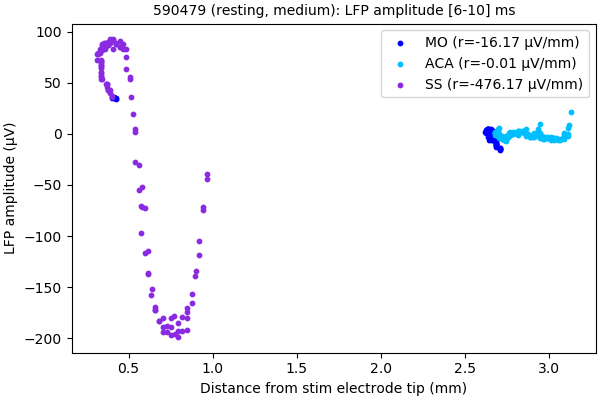

In [28]:
plot_stim_level = 'medium'
plot_state = 'resting'
amp_time = [0.006, 0.01] # [0.006, 0.01] [0.012, 0.016] [0.08, 0.12]

fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)

for regi in mdata['data']['LFP'][plot_stim_level][plot_state].keys():
    ch_dists = LFPtraces_info[regi]['ch_dists']
    LFP_timex = mdata['data']['LFP'][plot_stim_level][plot_state][regi][0]
    LFP_traces = np.mean(mdata['data']['LFP'][plot_stim_level][plot_state][regi][1], axis=2)
    ## Get mean amplitude in small window for all chs ##
    tinds = np.nonzero((LFP_timex > amp_time[0]) & (LFP_timex < amp_time[1]))[0]
    ch_amps = np.mean(LFP_traces[tinds, :], axis=0)
    
    res = stats.linregress(ch_dists, ch_amps)
    ax.scatter(ch_dists, ch_amps, c=area_colors[regi], s=10, label='{} (r={:.2f} \u03bcV/mm)'.format(regi, res.slope))

ax.set_xlabel('Distance from stim electrode tip (mm)')
ax.set_ylabel('LFP amplitude (\u03bcV)')
ax.legend()
ax.set_title('{} ({}, {}): LFP amplitude [{:d}-{:d}] ms'.format(
    mouse_num, plot_state, plot_stim_level, int(amp_time[0]*1E3), int(amp_time[1]*1E3)))

## Save ##
figname = '{}-{}_{}-{}_{:d}-{:d}ms_LFPvdist.png'.format(
    group, mouse_num, plot_state, plot_stim_level, int(amp_time[0]*1E3), int(amp_time[1]*1E3))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

<IPython.core.display.Javascript object>


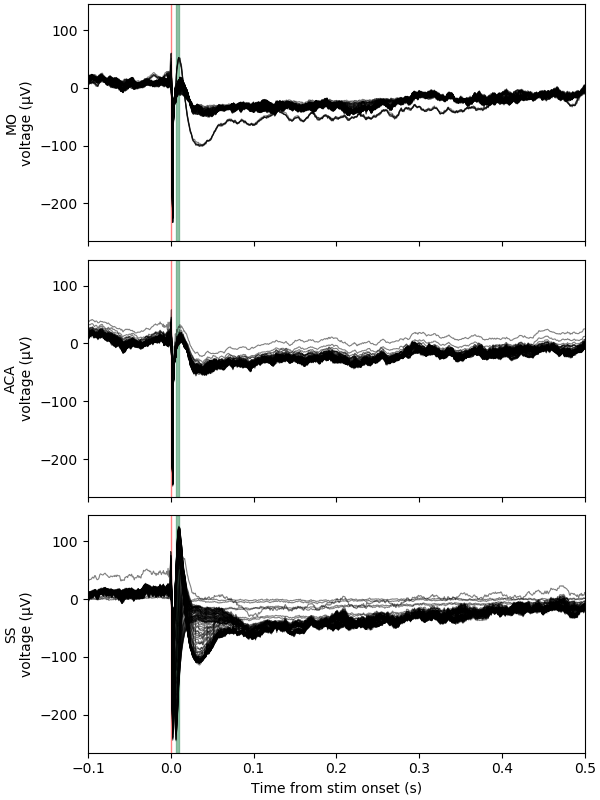

In [29]:
fig, axs = plt.subplots(
    len(mdata['data']['LFP'][plot_stim_level][plot_state]), figsize=(6,8), sharex=True, sharey=True, constrained_layout=True
)

for ax, regi in zip(axs, mdata['data']['LFP'][plot_stim_level][plot_state].keys()):
    LFP_timex = mdata['data']['LFP'][plot_stim_level][plot_state][regi][0]
    LFP_traces = np.mean(mdata['data']['LFP'][plot_stim_level][plot_state][regi][1], axis=2)
    ax.axvline(0, color='r', linewidth=1.0, alpha=0.5)
    ax.axvspan(amp_time[0], amp_time[1], color='seagreen', alpha=0.5)
    ax.plot(LFP_timex, LFP_traces, color='k', linewidth=0.8, alpha=0.5)
    ax.set_ylabel('{}\nvoltage (\u03bcV)'.format(regi))

ax.set_xlabel('Time from stim onset (s)')
ax.set_xlim([-0.1, 0.5])

## Save ##
figname = '{}-{}_{}-{}_{:d}-{:d}ms_LFPplots.png'.format(
    group, mouse_num, plot_state, plot_stim_level, int(amp_time[0]*1E3), int(amp_time[1]*1E3))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)